### Reference Notbooks
4. Natural language Processing IV (Section 5.4 thne 5.6)
4. NLP Exercise - do with student

### Steps to Follow
1. Try NaiveBayes classiffier first
2. Data Cleaning, lemming, etc
3. TFIDF
5. Try Random Forest (or K-means with only 2 clases?)

In [268]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate as tb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [269]:
# Importing the Training Data file
df = pd.read_csv('training_data_lowercase.csv', sep='\t', names=['tag', 'text'])
df.head(10)

,tag,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
5,0,racist alabama cops brutalize black boy while ...
6,0,fresh off the golf course
7,0,trump said some insanely racist stuff inside t...
8,0,former cia director slams trump over un bullying
9,0,brand-new pro-trump ad features so much a** ki...


In [270]:
#Defining target and features
X = df['text']
y = df['tag']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [271]:
### CLEAN AND TOKENIZE DATA
def clean_tokenize(phrase):
    return [word.lower() for word in word_tokenize(phrase) if word.isalpha()]

X_train_clean = X_train.apply(clean_tokenize)
X_test_clean = X_test.apply(clean_tokenize)

X_train_clean.head(10)

8891                                                  [so]
25115    [final, reckoning, approaches, for, obama, hig...
26933    [illinois, budget, talks, fizzle, amid, partis...
26971    [clinton, spokesman, ig, report, shows, no, cl...
11387    [busted, nancy, pelosi, claims, no, meeting, w...
9948     [heartwarming, hugs, and, kisses, from, potus,...
14165    [hillary, battle, plan, use, her, sex, offende...
14712    [radical, ny, attorney, general, cracking, dow...
11974                   [obama, blames, russia, for, loss]
30066    [factbox, one, planet, summit, turns, to, priv...
Name: text, dtype: object

In [272]:
# Train the Word2Vec model
w2v_model = Word2Vec(sentences=X_train_clean, vector_size=100, window=15, min_count=5, workers=4)

print(tb(w2v_model.wv.most_similar('fake'), headers=['Word', 'Similarity']))

Word        Similarity
--------  ------------
reporter      0.984846
bad           0.984718
hannity       0.982909
cnn           0.982177
wow           0.98155
caught        0.981274
liberal       0.980333
during        0.978978
down          0.978936
shut          0.978459


In [273]:
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_vect = X_train_clean.apply(lambda sentence: get_sentence_vector(sentence, w2v_model))
X_test_vect = X_test_clean.apply(lambda sentence: get_sentence_vector(sentence, w2v_model))

In [274]:
### Lemmatization
""" def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a sentence or text
def lemmatize_text(words):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

X_train_lm = X_train_clean.apply(lemmatize_text)
X_test_lm = X_test_clean.apply(lemmatize_text) """

' def get_wordnet_pos(word):\n    tag = nltk.pos_tag([word])[0][1][0].upper()\n    tag_dict = {"J": wordnet.ADJ,\n                "N": wordnet.NOUN,\n                "V": wordnet.VERB,\n                "R": wordnet.ADV}\n    return tag_dict.get(tag, wordnet.NOUN)\n\n# Initialize the lemmatizer\nlemmatizer = WordNetLemmatizer()\n\n# Define a function to lemmatize a sentence or text\ndef lemmatize_text(words):\n    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]\n\nX_train_lm = X_train_clean.apply(lemmatize_text)\nX_test_lm = X_test_clean.apply(lemmatize_text) '

In [275]:
# Remove stopwords
""" def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

X_train_sw = X_train_lm.apply(remove_stopwords)
X_test_sw = X_test_lm.apply(remove_stopwords) """

" def remove_stopwords(words):\n    stop_words = set(stopwords.words('english'))\n    return [word for word in words if word not in stop_words]\n\nX_train_sw = X_train_lm.apply(remove_stopwords)\nX_test_sw = X_test_lm.apply(remove_stopwords) "

In [276]:
# Recompose the phrases
""" X_train_final = X_train_sw.apply(lambda row: " ".join(row))
X_test_final = X_test_sw.apply(lambda row: " ".join(row)) """

' X_train_final = X_train_sw.apply(lambda row: " ".join(row))\nX_test_final = X_test_sw.apply(lambda row: " ".join(row)) '

In [277]:
## Vectorization
""" bow_vect = CountVectorizer(max_features=1000)

# fit creates one entry for each different word seen
X_train_vect = bow_vect.fit_transform(X_train_final).toarray()
X_test_vect = bow_vect.transform(X_test_final).toarray() """

' bow_vect = CountVectorizer(max_features=1000)\n\n# fit creates one entry for each different word seen\nX_train_vect = bow_vect.fit_transform(X_train_final).toarray()\nX_test_vect = bow_vect.transform(X_test_final).toarray() '

In [278]:
### Logistic Regression
lr_model = LogisticRegression().fit(list(X_train_vect), y_train)
## Predict for the Test Dataset
y_pred = lr_model.predict(list(X_test_vect))

In [279]:
### XGB Classifier
""" xgb_model = XGBClassifier().fit(list(X_train_vect), y_train)
## Predict for the Test Dataset
y_pred = xgb_model.predict(list(X_test_vect)) """

' xgb_model = XGBClassifier().fit(list(X_train_vect), y_train)\n## Predict for the Test Dataset\ny_pred = xgb_model.predict(list(X_test_vect)) '

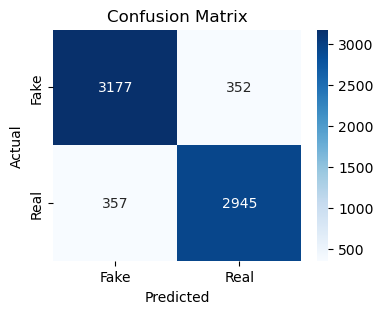

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      3529
           1       0.89      0.89      0.89      3302

    accuracy                           0.90      6831
   macro avg       0.90      0.90      0.90      6831
weighted avg       0.90      0.90      0.90      6831

Accuracy Score: 0.8962


In [280]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

acc_score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc_score:.4f}")